<a href="https://colab.research.google.com/github/sispo3314/AI_study/blob/main/WISDM/wisdm_transformer_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('/content/drive/MyDrive/datasets/WISDM_ar_v1.1_raw.txt', header=None, on_bad_lines='skip').dropna()

In [3]:
df.columns=['user', 'activity', 'timestamp', 'x','y','z']
df['z']=df['z'].str.replace(';','')
df=df.drop(columns=['timestamp'])
df.head()

,user,activity,x,y,z
0,33,Jogging,-0.694638,12.680544,0.50395286
1,33,Jogging,5.012288,11.264028,0.95342433
2,33,Jogging,4.903325,10.882658,-0.08172209
3,33,Jogging,-0.612916,18.496431,3.0237172
4,33,Jogging,-1.184970,12.108489,7.205164


In [4]:
df['x']=df['x'].astype(float)
df['y']=df['y'].astype(float)
df['z']=df['z'].astype(float)

In [5]:
df.isnull().sum()

,0
user,0
activity,0
x,0
y,0
z,0


In [6]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
df['activity']=label.fit_transform(df['activity'])
df

,user,activity,x,y,z
0,33,1,-0.694638,12.680544,0.503953
1,33,1,5.012288,11.264028,0.953424
2,33,1,4.903325,10.882658,-0.081722
3,33,1,-0.612916,18.496431,3.023717
4,33,1,-1.184970,12.108489,7.205164
...,...,...,...,...,...
1086461,19,2,9.000000,-1.570000,1.690000
1086462,19,2,9.040000,-1.460000,1.730000
1086463,19,2,9.080000,-1.380000,1.690000
1086464,19,2,9.000000,-1.460000,1.730000


In [7]:
X=df.drop(columns=['activity'])
y=df['activity']
X

,user,x,y,z
0,33,-0.694638,12.680544,0.503953
1,33,5.012288,11.264028,0.953424
2,33,4.903325,10.882658,-0.081722
3,33,-0.612916,18.496431,3.023717
4,33,-1.184970,12.108489,7.205164
...,...,...,...,...
1086461,19,9.000000,-1.570000,1.690000
1086462,19,9.040000,-1.460000,1.730000
1086463,19,9.080000,-1.380000,1.690000
1086464,19,9.000000,-1.460000,1.730000


In [8]:
y

,activity
0,1
1,1
2,1
3,1
4,1
...,...
1086461,2
1086462,2
1086463,2
1086464,2


In [9]:
users=sorted(df['user'].unique())
print(users)

[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]


In [10]:
#train, test 분리
train_users=[u for u in users if u<=28]
val_users=[u for u in users if 28<u<=32]
test_users=[u for u in users if u>32]

#사용자 그룹에 따라 DataFrame 생성
train_df = df[df['user'].isin(train_users)].copy()
test_df  = df[df['user'].isin(test_users)].copy()
val_df=df[df['user'].isin(val_users)].copy()

print("-----사용자 기반 데이터 분할-----")
print(f"훈련용 사용자 수: {len(train_users)}명, 데이터 수: {len(train_df)}")
print(f"검증용 사용자 수: {len(val_users)}명, 데이터 수: {len(val_df)}")
print(f"테스트용 사용자 수: {len(test_users)}명, 데이터 수: {len(test_df)}")

-----사용자 기반 데이터 분할-----
훈련용 사용자 수: 28명, 데이터 수: 823043
검증용 사용자 수: 4명, 데이터 수: 143367
테스트용 사용자 수: 4명, 데이터 수: 120055


In [11]:
#데이터 스케일링
from sklearn.preprocessing import StandardScaler

features=['x','y','z']
scaler=StandardScaler()
#스케일링은 무조건 훈련 데이터 기준으로... 테스트 데이터 기준으로 하면=> 데이터 누수!!!!!
scaler.fit(train_df[features])

train_df[features]=scaler.transform(train_df[features])
val_df[features]=scaler.transform(val_df[features])
test_df[features]=scaler.transform(test_df[features])

In [12]:
import numpy as np
from scipy.stats import mode
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x'].values[i:i+time_steps]
        ys = df['y'].values[i:i+time_steps]
        zs = df['z'].values[i:i+time_steps]

        win_labels = df[label_name].values[i:i+time_steps].astype(int)
        label = np.bincount(win_labels).argmax()
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [13]:
TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activity'

In [14]:
#훈련 데이터셋
x_train, y_train=segments(train_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#검증 데이터셋
x_val, y_val=segments(val_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#테스트 데이터셋
x_test, y_test=segments(test_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

In [15]:
#원핫인코딩
from tensorflow.keras.utils import to_categorical

num_classes=label.classes_.size
y_train_hot=to_categorical(y_train, num_classes)
y_val_hot=to_categorical(y_val, num_classes)
y_test_hot=to_categorical(y_test, num_classes)

print("훈련데이터:", x_train.shape, y_train_hot.shape)
print("검증데이터", x_val.shape, y_val_hot.shape)

훈련데이터: (20575, 80, 3) (20575, 6)
검증데이터 (3583, 80, 3) (3583, 6)


In [16]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIOD, 3, 1)
x_val = x_val.reshape(x_val.shape[0], TIME_PERIOD, 3, 1)
x_test = x_test.reshape(x_test.shape[0], TIME_PERIOD, 3, 1)

x_train.shape, x_val.shape

((20575, 80, 3, 1), (3583, 80, 3, 1))

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, GlobalAveragePooling1D, # GlobalAveragePooling2D 대신 1D 사용
                                     Dense, Reshape, Add, LayerNormalization,
                                     BatchNormalization, Dropout, MultiHeadAttention) # MultiHeadAttention, LayerNormalization 추가
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

## Transformer encoder

In [18]:
def transformer_encoder_block(inputs, num_heads, key_dim, ff_dim, dropout_rate=0.1):
  #inputs: 입력 텐서, num_heads: 멀티 헤드 어텐션 head 수, key_dim: 각 헤드의 차원, ff_dim: 네트워크 내부 유닛 수
  #1. Multi Head Self Attention
  mha=MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
  #셀프 어텐션: 쿼리, 값, 키 전부 inputs
  attention_output=mha(query=inputs, value=inputs, key=inputs)

  attention_output=Dropout(dropout_rate)(attention_output)
  out1=LayerNormalization(epsilon=1e-6)(Add()([inputs, attention_output]))

  #2. Feed Forward Network
  ffn_output=Dense(ff_dim, activation='relu')(out1)
  ffn_output=Dense(inputs.shape[-1])(ffn_output) #원래 차원으로...
  #드롭아웃, Residual Connection
  ffn_output=Dropout(dropout_rate)(ffn_output)

  out2=LayerNormalization(epsilon=1e-6)(Add()([out1, ffn_output]))

  return out2

In [59]:
#CNN+트랜스포머 모델 함수
from tensorflow.keras.regularizers import l2
def create_cnn_transformer(input_shape, num_classes, num_transformer_blocks=2,
                           num_heads=4, ff_dim=64, cnn_filters=32, dropout_rate=0.4):
  #input_shape: 입력 데이터 shape, num_classes: 분류할 클래스 수, num_transformer_blocks: 트랜스포머 블록 수
  #num_heads: 어텐션 헤드 수, ff_dim: FFN 내부 유닛 수
  inputs=Input(shape=input_shape)

  #CNN 특징 추출
  x=Conv2D(cnn_filters, kernel_size=(3,1), padding='same', activation='relu',kernel_regularizer=l2(0.001))(inputs)
  x=BatchNormalization()(x)
  x=Conv2D(cnn_filters, kernel_size=(3,1), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
  x=BatchNormalization()(x)

  #트랜스포머 입력 형태로 변환하기 (batch, sequence_length, features)
  time_steps=input_shape[0]
  embed_dim=input_shape[1]*cnn_filters
  x=Reshape((time_steps, embed_dim))(x)

  #멀티헤드어텐션의 key_dim 계산
  key_dim=embed_dim//num_heads

  #트랜스포머 인코더 블록
  for _ in range(num_transformer_blocks):
    x=transformer_encoder_block(x, num_heads, key_dim, ff_dim, dropout_rate)
  #분류기 헤드
  x=GlobalAveragePooling1D()(x)
  x=Dropout(0.4)(x)
  outputs=Dense(num_classes, activation='softmax')(x)

  model=Model(inputs=inputs, outputs=outputs)
  return model


In [60]:
#모델 생성
input_shape=x_train.shape[1:]
num_classes=y_train_hot.shape[1]

model=create_cnn_transformer(
    input_shape,
    num_classes,
    num_transformer_blocks=1,
    num_heads=4,
    ff_dim=64,
    cnn_filters=32,
    dropout_rate=0.4
)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 80, 3, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 80, 3, 32) │        128 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 32) │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 80, 3, 32) │      3,104 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 32) │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 80, 96)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 80, 96)    │     37,248 │ reshape_6[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_6[0][0],  │
│                     │                   │            │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 80, 96)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 80, 96)    │          0 │ reshape_6[0][0],  │
│                     │                   │            │ dropout_45[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 80, 96)    │        192 │ add_24[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 80, 64)    │      6,208 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 80, 96)    │      6,240 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 80, 96)    │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 80, 96)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_46[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 80, 96)    │        192 │ add_25[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 96)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 96)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 6)         │        582 │ dropout_47[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 54,150 (211.52 KB)

 Trainable params: 54,022 (211.02 KB)

 Non-trainable params: 128 (512.00 B)

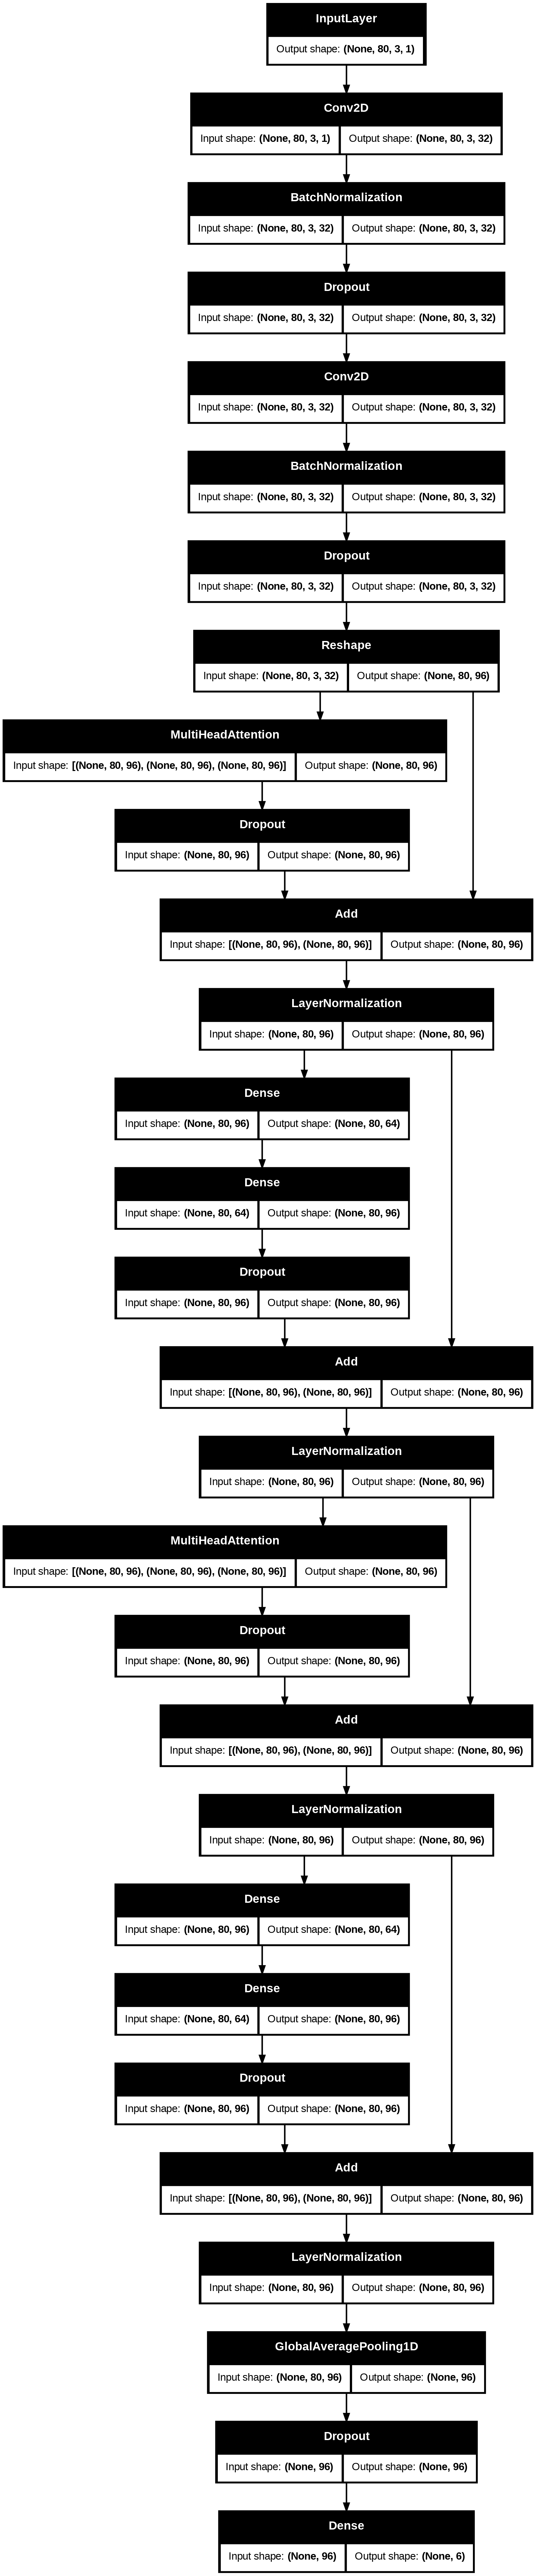

In [52]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [61]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

history = model.fit(x_train, y_train_hot,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val_hot),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.7857 - loss: 0.6520 - val_accuracy: 0.7700 - val_loss: 0.6691 - learning_rate: 0.0010
Epoch 2/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9101 - loss: 0.2826 - val_accuracy: 0.8038 - val_loss: 0.9151 - learning_rate: 0.0010
Epoch 3/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9336 - loss: 0.2256 - val_accuracy: 0.8253 - val_loss: 0.8892 - learning_rate: 0.0010
Epoch 4/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9495 - loss: 0.1833 - val_accuracy: 0.8205 - val_loss: 0.6660 - learning_rate: 0.0010
Epoch 5/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9531 - loss: 0.1710 - val_accuracy: 0.7915 - val_loss: 0.8154 - learning_rate: 0.0010
Epoch 6/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9584 - loss: 0.1515 - val_accuracy: 0.8225 - val_loss: 0.9328 - learning_rate: 0.0010
Epoch 7/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9602 - loss: 0.1453 

In [62]:
import matplotlib.pyplot as plt
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epochs_run = len(history.history['loss'])
  epoch_range = range(1, epochs_run+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

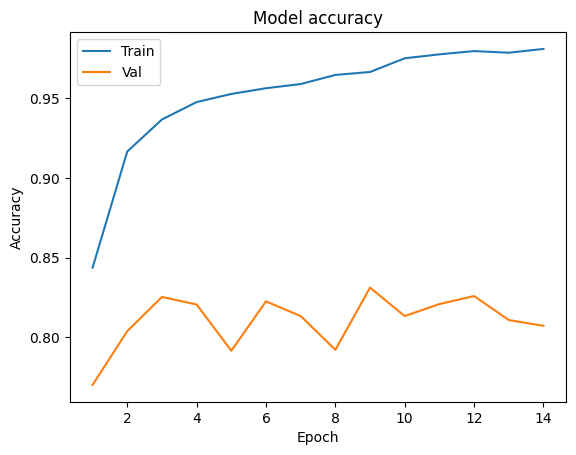

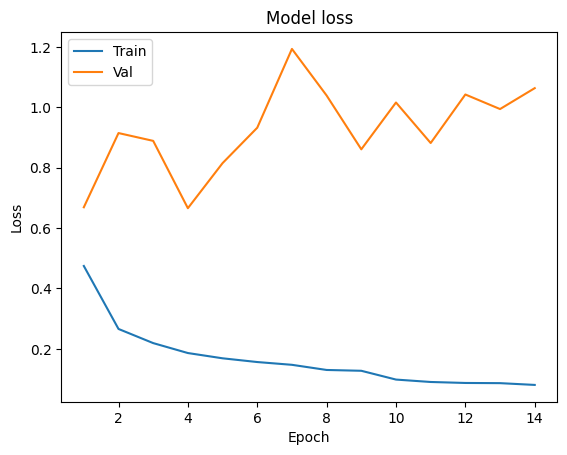

In [63]:
plot_learningCurve(history, 50)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


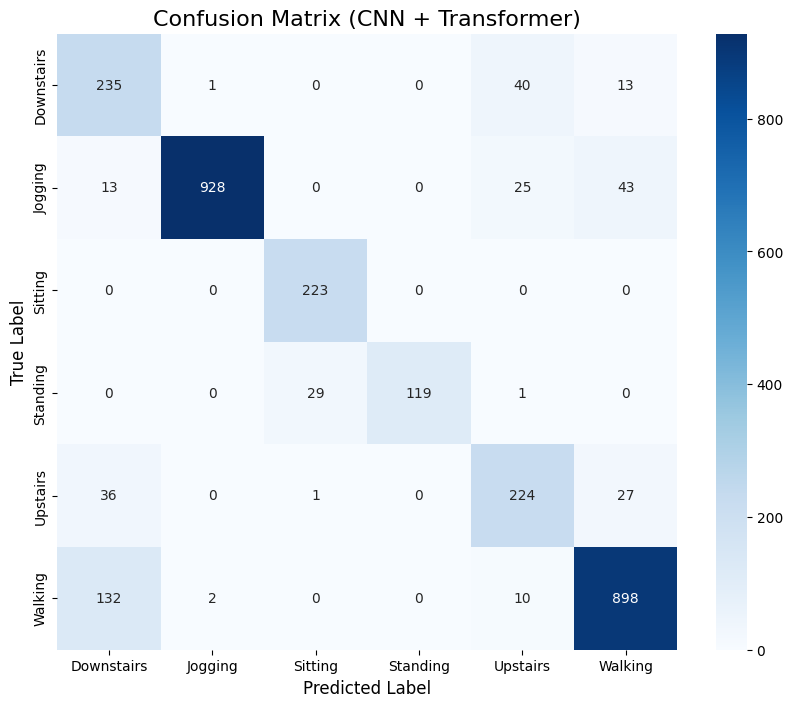

In [64]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label.classes_, yticklabels=label.classes_)
plt.title('Confusion Matrix (CNN + Transformer)', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [65]:
loss, accuracy = model.evaluate(x_test, y_test_hot, verbose=0)
print("="*30)
print(f"테스트 데이터 정확도 (Accuracy): {accuracy:.4f}")
print(f"테스트 데이터 손실 (Loss): {loss:.4f}")
print("="*30)

테스트 데이터 정확도 (Accuracy): 0.8757
테스트 데이터 손실 (Loss): 0.6005


In [66]:
from sklearn.metrics import classification_report

print("\n===== 분류 리포트 (CNN + Transformer) =====")
print(classification_report(y_test, y_pred, target_names=label.classes_))


===== 분류 리포트 (CNN + Transformer) =====
              precision    recall  f1-score   support

  Downstairs       0.56      0.81      0.67       289
     Jogging       1.00      0.92      0.96      1009
     Sitting       0.88      1.00      0.94       223
    Standing       1.00      0.80      0.89       149
    Upstairs       0.75      0.78      0.76       288
     Walking       0.92      0.86      0.89      1042

    accuracy                           0.88      3000
   macro avg       0.85      0.86      0.85      3000
weighted avg       0.89      0.88      0.88      3000

